# Baseline DL Model

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

## Loading Data

In [2]:
data = pd.read_csv('../raw_data/merged_data.csv')
data

,text,is_fake
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1
...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0
38654,"LexisNexis, a provider of legal, regulatory an...",0
38655,In the shadow of disused Soviet-era factories ...,0
38656,Vatican Secretary of State Cardinal Pietro Par...,0


## Preprocessing Data

In [3]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

### Create new column with clean text

In [4]:
%%time

data['text_clean'] = data['text'].apply(cleaning)
data

CPU times: user 1min 58s, sys: 3.22 s, total: 2min 1s
Wall time: 2min 2s


,text,is_fake,text_clean
0,Donald Trump just couldn t wish all Americans ...,1,donald trump wish americans happy new year lea...
1,House Intelligence Committee Chairman Devin Nu...,1,house intelligence committee chairman devin nu...
2,"On Friday, it was revealed that former Milwauk...",1,friday reveal former milwaukee sheriff david c...
3,"On Christmas day, Donald Trump announced that ...",1,christmas day donald trump announce would back...
4,Pope Francis used his annual Christmas Day mes...,1,pope francis use annual christmas day message ...
...,...,...,...
38653,NATO allies on Tuesday welcomed President Dona...,0,nato ally tuesday welcome president donald tru...
38654,"LexisNexis, a provider of legal, regulatory an...",0,lexisnexis provider legal regulatory business ...
38655,In the shadow of disused Soviet-era factories ...,0,shadow disused sovietera factories minsk stree...
38656,Vatican Secretary of State Cardinal Pietro Par...,0,vatican secretary state cardinal pietro paroli...


### Features and Target

In [5]:
X = data.text_clean
y = data.is_fake

## Training Data

### Train Validation Test Split

In [6]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Tokenize + Pad Data

In [7]:
%%time
# max_words = 10000  
# max_sequence_length = 500  

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_sequence_length = 500

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='pre')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='pre')

CPU times: user 13.8 s, sys: 186 ms, total: 14 s
Wall time: 14 s


### Define, Compile, Train Model

In [13]:
%%time

# Define the RNN model
embedding_dim = 50 
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the zero-padding index
dropout_rate = 0.2
l2_strength = 1e-4

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(2, kernel_regularizer=l2(l2_strength)))  # L2 regularization added
model.add(Dropout(dropout_rate))  # Dropout regularization added
model.add(Dense(1, activation='sigmoid'))

CPU times: user 488 ms, sys: 97.7 ms, total: 586 ms
Wall time: 449 ms


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
%%time

# Train the model
epochs = 5  

history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_val_padded, y_val))

Epoch 1/5
846/846 [==============================] - 140s 162ms/step - loss: 0.3743 - accuracy: 0.9334 - val_loss: 0.1923 - val_accuracy: 0.9736
Epoch 2/5
846/846 [==============================] - 138s 164ms/step - loss: 0.1714 - accuracy: 0.9630 - val_loss: 0.1258 - val_accuracy: 0.9752
Epoch 3/5
846/846 [==============================] - 140s 165ms/step - loss: 0.1158 - accuracy: 0.9713 - val_loss: 0.0882 - val_accuracy: 0.9819
Epoch 4/5
846/846 [==============================] - 139s 165ms/step - loss: 0.0858 - accuracy: 0.9752 - val_loss: 0.0807 - val_accuracy: 0.9819
Epoch 5/5
846/846 [==============================] - 139s 164ms/step - loss: 0.0770 - accuracy: 0.9755 - val_loss: 0.0909 - val_accuracy: 0.9755
CPU times: user 31min 13s, sys: 5min 48s, total: 37min 2s
Wall time: 11min 36s


## Evaluate Model on Test Data

In [16]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)

182/182 [==============================] - 4s 21ms/step - loss: 0.0957 - accuracy: 0.9731


In [17]:
# Make predictions on the test set
predictions = model.predict(X_test_padded)

# Convert probabilities to class labels (0 or 1 for binary classification)
predicted_labels = (predictions > 0.5).astype(int)

182/182 [==============================] - 4s 20ms/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, predicted_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3209
           1       0.97      0.97      0.97      2590

    accuracy                           0.97      5799
   macro avg       0.97      0.97      0.97      5799
weighted avg       0.97      0.97      0.97      5799


Confusion Matrix:
[[3136   73]
 [  83 2507]]


## History + Learning Curves

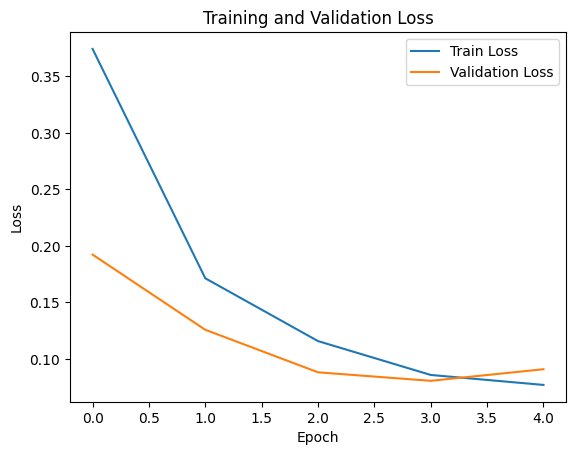

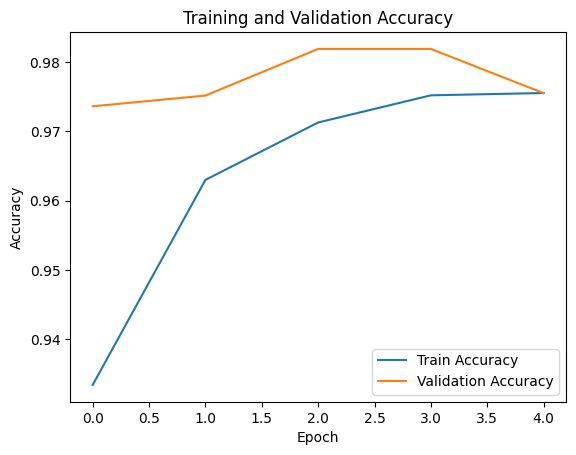

In [19]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## New Text Prediction

In [20]:
from keras.models import load_model

# Save the trained model to a file
model.save('rnn_model_adj.h5')

# Load the saved RNN model
model = load_model('rnn_model_adj.h5')

In [ ]:
# New text to classify
new_text = '''Former President Donald J. Trump, who has been indicted by federal prosecutors for conspiracy to defraud the United States in connection with a plot to overturn the 2020 election, repeatedly claimed to supporters in Iowa on Saturday that it was President Biden who posed a severe threat to American democracy.

While Mr. Trump shattered democratic norms throughout his presidency and has faced voter concerns that he would do so again in a second term, the former president in his speech repeatedly accused Mr. Biden of corrupting politics and waging a repressive “all-out war” on America.

”Joe Biden is not the defender of American democracy,” he said. “Joe Biden is the destroyer of American democracy.”

Mr. Trump has made similar attacks on Mr. Biden a staple of his speeches in Iowa and elsewhere. He frequently accuses the president broadly of corruption and of weaponizing the Justice Department to influence the 2024 election.

But in his second of two Iowa speeches on Saturday, held at a community college gym in Cedar Rapids, Mr. Trump sharpened that line of attack, suggesting a more concerted effort by his campaign to defend against accusations that Mr. Trump has an anti-democratic bent — by going on offense.

Polls have shown that significant percentages of voters in both parties are concerned about threats to democracy. During the midterm elections, candidates who embraced Mr. Trump’s lie that the 2020 election was stolen from him were defeated, even in races in which voters did not rank “democracy” as a top concern.

Mr. Biden’s re-election campaign has frequently attacked Mr. Trump along those lines. In recent weeks, Biden aides and allies have called attention to news reports about plans being made by Mr. Trump and his allies that would undermine central elements of American democracy, governing and the rule of law.

Mr. Trump and his campaign have sought to dismiss such concerns as a concoction to scare voters. But on Saturday, they tried to turn the Biden campaign’s arguments back against the president.

At the Cedar Rapids event, aides and volunteers left placards with bold black-and-white lettering reading “Biden attacks democracy” on the seats and bleachers. At the start of Mr. Trump's speech, that message was broadcast on a screen above the stage.

Mr. Trump has a history of accusing his opponents of behavior that he himself is guilty of, the political equivalent of a “No, you are” playground retort. In a 2016 debate, when Hillary Clinton accused Mr. Trump of being a Russian puppet, Mr. Trump fired back with “You’re the puppet,” a comment he never explained.

Mr. Trump’s accusations against Mr. Biden, which he referenced repeatedly throughout his speech, veered toward the conspiratorial. He claimed the president and his allies were seeking to control Americans’ speech, their behavior on social media and their purchases of cars and dishwashers.

Without evidence, he accused Mr. Biden of being behind a nationwide effort to get Mr. Trump removed from the ballot in several states. And, as he has before, he claimed, again without evidence, that Mr. Biden was the mastermind behind the four criminal cases against him.

Here, too, Mr. Trump conjured a nefarious-sounding presidential conspiracy, one with dark ramifications for ordinary Americans, not just for the former president being prosecuted. Mr. Biden and his allies “think they can do whatever they want,” Mr. Trump said — “break any law, tell any lie, ruin any life, trash any norm, and get away with anything they want. Anything they want.”

Democrats suggested that the former president was projecting again.

“Donald Trump’s America in 2025 is one where the government is his personal weapon to lock up his political enemies,” Ammar Moussa, a spokesman for Mr. Biden’s re-election campaign, said in a statement. “You don’t have to take our word for it — Trump has admitted it himself.”

Even as he was insisting that Mr. Biden threatens democracy, Mr. Trump underscored his most antidemocratic campaign themes.

Having said that he would use the Justice Department to “go after” the Biden family,  on Saturday, he swore that he would “investigate every Marxist prosecutor in America for their illegal, racist-in-reverse enforcement of the law.”

Mr. Trump has frequently decried the cases brought him against by Black prosecutors in New York and Atlanta as racist. (He does not apply that charge to the white special counsel in his two federal criminal cases, who he instead calls “deranged.”)

Yet Mr. Trump himself has a history of racist statements.

At an earlier event on Saturday, where he sought to undermine confidence in election integrity well before the 2024 election, he urged supporters in Ankeny, a predominantly white suburb of Des Moines, to take a closer look at election results next year in Detroit, Philadelphia and Atlanta, three cities with large Black populations in swing states that he lost in 2020.

“You should go into some of these places, and we’ve got to watch those votes when they come in,” Mr. Trump said. “When they’re being, you know, shoved around in wheelbarrows and dumped on the floor and everyone’s saying, ‘What’s going on?’

“We’re like a third-world nation,” he added.

Mr. Trump’s speeches on Saturday reflected how sharply he is focused on the general election rather than the Republican primary contest, in which he holds a commanding lead.

With just over six weeks until the Iowa caucus, Mr. Trump dismissed his Republican rivals, mocking them for polling well behind him and denouncing Gov. Ron DeSantis of Florida as disloyal for deciding to run against him.

He also attacked Iowa’s Republican governor, Kim Reynolds, for endorsing Mr. DeSantis and suggested her popularity had tumbled after she had spurned Mr. Trump.

“You know, with your governor we had an issue,” Mr. Trump said, prompting a chorus of boos.'''

# Preprocess the new text using the same tokenizer
new_text_sequences = tokenizer.texts_to_sequences([new_text])
new_text_padded = pad_sequences(new_text_sequences, maxlen=max_sequence_length)

# Make predictions using the loaded RNN model
prediction = model.predict(new_text_padded)

# Interpret the prediction
if prediction[0, 0] >= 0.5:
    print("The text is classified as fake.")
else:
    print("The text is classified as real.")